In [1]:
%matplotlib inline
import warnings
from numpy import *
from numpy.linalg import norm
from matplotlib.pyplot import *
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': False,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
rcParams.update(newparams)
warnings.filterwarnings('ignore')

### Oppgave 1

In [2]:
def lotka_volterra(x, y):
    alpha, beta, delta, gamma = 2, 1, 0.5, 1
    dy = array([alpha*y[0]-beta*y[0]*y[1], 
                delta*y[0]*y[1]-gamma*y[1]])
    return dy

In [3]:
def heun_euler(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x+h, y+h*k1)
    y_next = y + 0.5*h*(k1+k2)
    x_next = x + h
    error_estimate = 0.5*h*norm(k2-k1)   # The 2-norm or the error estimate
    p = 1
    return x_next, y_next, error_estimate, p

In [4]:
def bogacki_shampine(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h/2, y + h/2 * k1)
    k3 = f(x + 3*h/4, y + 3*h/4 * k2)
    k4 = f(x + h, y + h/3 *(2/3 * k1 + k2 + 4/3 * k3))
    x_next = x + h
    y_next = y + h/3 * (1/3 * k1 + k2 + 4/3 * k3)
    error_estimate = h * norm(-5/72 * k1 + 1/12 * k2 + 1/9 * k3 - 1/8 * k4)
    p = 2
    return x_next, y_next, error_estimate, p

In [5]:
def ode_adaptive(f, x0, xend, y0, h0, tol = 1.e-6, method=heun_euler):
    # Initialization 
    x_num = array([x0])    # Array for the x-values
    y_num = array([y0])    # Array for the solutions y
    xn, yn, h = x0, y0, h0
    n_calls, max_calls = 0, 10000000
    
    # Main loop
    while xn < xend - 1.e-10:   # Buffer for truncation error
        # Adjust the stepsize for the last step
        if xn + h > xend:                   
            h = xend - xn 
        
        # Perform one iteration of given method pair
        x_try, y_try, error_estimate, p = method(f, xn, yn, h)
        n_calls += 1
        
        # Check if solution from current iteration is to be accepted
        if error_estimate <= tol:   
            # Accept solutions
            xn, yn = x_try, y_try
            
            # Store the solutions 
            y_num = concatenate((y_num, array([yn])))
            x_num = append(x_num, xn)
        
        # Adjust the stepsize
        h = 0.8*(tol/error_estimate)**(1/(p+1))*h
        
        # Stop with a warning in the case of max calls to method
        if n_calls > max_calls:
            print('Maximum number of method calls')
            return x_num, y_num

    # Some diagnostic output
    acc_calls = len(x_num)-1
    rej_calls = n_calls - len(x_num)+1
    print(f"Method: {method.__name__:<20}   Tol: {tol:<10.0e}   Accepted: {acc_calls:<10}   Rejected: {rej_calls:<10}")
    return x_num, y_num

Method: heun_euler             Tol: 1e-03        Accepted: 677          Rejected: 1         
Method: heun_euler             Tol: 1e-05        Accepted: 6764         Rejected: 1         
Method: heun_euler             Tol: 1e-07        Accepted: 67635        Rejected: 1         
Method: bogacki_shampine       Tol: 1e-03        Accepted: 83           Rejected: 7         
Method: bogacki_shampine       Tol: 1e-05        Accepted: 394          Rejected: 1         
Method: bogacki_shampine       Tol: 1e-07        Accepted: 1844         Rejected: 1         


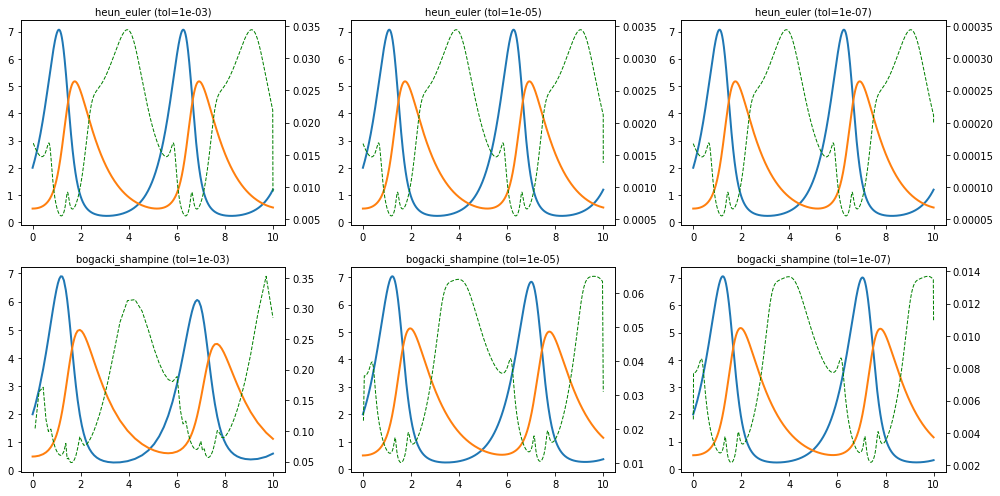

In [6]:
x0, xend = 0, 10
y0 = array([2, 0.5])
h0 = 1
methods = (heun_euler, bogacki_shampine)
tolerances = (1e-3, 1e-5, 1e-7)

f, axarr = subplots(len(methods), len(tolerances), figsize=(14,7))
for i, method in enumerate(methods):
    for j, tol in enumerate(tolerances):
        # Find solutions
        x_num, y_num = ode_adaptive(lotka_volterra, x0, xend, y0, h0, tol=tol, method=method)
        h_num = [x2 - x1 for x1, x2 in zip(x_num, x_num[1:])]
        
        # Plot solutions
        axarr[i, j].plot(x_num, y_num, linewidth=2.0)
        axarr[i, j].set_title(f"{method.__name__} (tol={tol:.0e})", size=10)
        axarr[i, j].tick_params(axis='both', labelsize=10)
        
        # Plot step size on right axis
        ax2 = axarr[i, j].twinx()
        ax2.plot(x_num[1:], h_num, 'g--', linewidth=1.0)
        ax2.tick_params(axis='y', labelsize=10)
        
tight_layout()

### Oppgave 3

In [7]:
def ode_solver(f, x0, xend, y0, h, method):
    # Initialization
    y_num = array([y0])    # Array for the solution y 
    x_num = array([x0])    # Array for the x-values

    xn = x0                # Running values for x and y
    yn = y0 

    # Main loop
    while xn < xend - 1.e-10:            # Buffer for truncation errors        
        xn, yn = method(f, xn, yn, h)    # Do one step by the method of choice
        
        # Extend the arrays for x and y
        y_num = concatenate((y_num, array([yn])))
        x_num = append(x_num, xn)
        
    return x_num, y_num

In [8]:
def RK3(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h/2, y + h*k1/2)
    k3 = f(x + h, y + h*(-1*k1 + 2*k2))
    return x + h, y + h*(k1/6 + 2*k2/3 + k3/6)

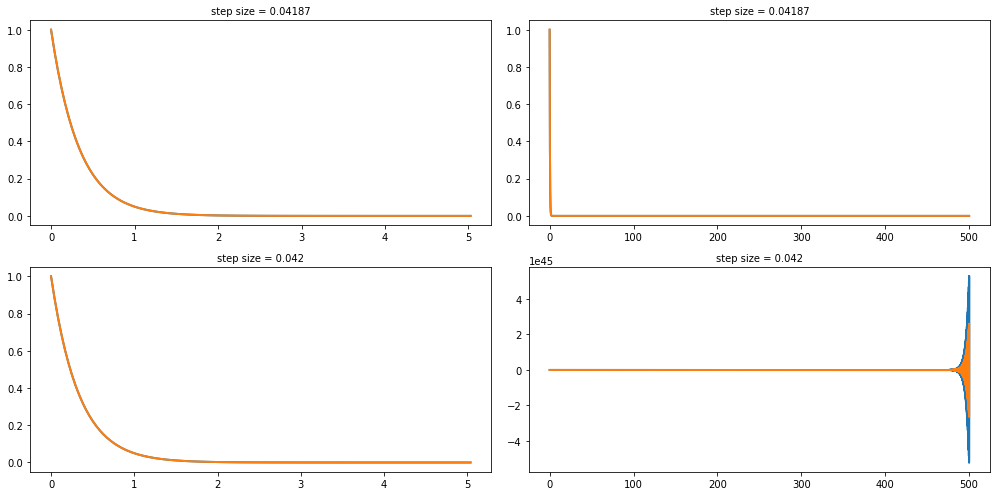

In [29]:
def f(_, y):
    return array([-41*y[0] + 38*y[1], 19*y[0] -22*y[1]])

intervals = ((0, 5), (0, 500))
steps = (4.187e-2, 4.20e-2)
y0 = array([1, 1])

fig, axarr = subplots(len(intervals), len(steps), figsize=(14,7))
for i, h in enumerate(steps):
    for j, interval in enumerate(intervals):
        # Find solutions
        x0, xend = interval
        x_num, y_num = ode_solver(f, x0, xend, y0, h, method)
        
        # Plot solutions
        axarr[i, j].plot(x_num, y_num, linewidth=2.0)
        axarr[i, j].set_title(f"step size = {h}", size=10)
        axarr[i, j].tick_params(axis='both', labelsize=10)
        
tight_layout()